In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoConfig
from transformers.models.llama.modeling_llama import *
from tqdm import tqdm
import torch as torch
import torch.nn as nn
from scipy.stats import gaussian_kde
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hf_auth_token = "" #REPLACE_WITH_YOUR_HUGGINGFACE_TOKEN

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/om2/user/jack

In [2]:
def initialize_weights(module, distribution, attention_sigma, mlp_sigma):
    for name, param in module.named_parameters():
        if "v_proj" in name or "o_proj" in name:
            nn.init.normal_(param, 0, np.sqrt(1/param.shape[0]))
        elif "bias" in name:
            nn.init.zeros_(param)
        elif "layernorm" in name:
            continue
        else:
            if "q_proj" in name or "k_proj" in name:
                variance = attention_sigma / param.shape[0]
            else:
                variance = mlp_sigma**2 / param.shape[0]

            if distribution == "uniform":
                width = np.sqrt(variance * 12) / 2
                nn.init.uniform_(param, -width, width)
            elif distribution == "normal":
                nn.init.normal_(param, 0, np.sqrt(variance))


# Single Layer Test

In [4]:
def layer_norm(input):
    return math.sqrt(input.shape[-1]) * input / torch.norm(input, dim=-1, keepdim=True)

def forward_pass(attention, mlp, input, position_ids):
    mlp.eval()
    attention.eval()
    residual = input
    with torch.no_grad():
        hidden_state = layer_norm(residual)
        attention_output = attention(hidden_state, position_ids=position_ids)[0]
        residual = attention_output + residual
        hidden_state = layer_norm(residual)
        mlp_output = mlp(hidden_state)[0]
    return mlp_output + residual

def generate_input(n, d, correlation):
    # Generate the "tokens" as described in the paper 

    # Step 1: Generate base vectors
    # Generate n independent Gaussian vectors of dimension d
    independent_vectors = np.random.normal(size=(n, d))

    # Step 2: Create correlation matrix and get Cholesky decomposition
    correlation_matrix = np.full((n, n), correlation)
    np.fill_diagonal(correlation_matrix, 1.0)
    L = np.linalg.cholesky(correlation_matrix)

    # Step 3: Apply Cholesky factor to correlate vectors
    # `correlated_vectors` now has the desired correlations across vectors
    input = L @ independent_vectors  # Shape: (n, d)

    input = torch.tensor(input, dtype=torch.float32)

    input = input.unsqueeze(0)

    return input

# def generate_input(n, d, correlation):
#     return np.random.normal(size=(n, d))

def calculate_pq(input):
    # Compute dot product matrix
    dot_product_matrix = input @ input.T

    # Extract norms (diagonal) and average norm
    q = np.mean(np.diag(dot_product_matrix))

    # Extract dot products (off-diagonal) and average dot product
    p = np.mean(dot_product_matrix[np.triu_indices(len(input), k=1)])
    
    return p, q

def calculate_lyapunov_exponent(p, q, p_prime, q_prime):
    numerator = 1 - p_prime/q_prime
    denominator = 1 - p/q
    return np.log(numerator/denominator)

## Lyapunov exponent over one layer

In [7]:
model_name = "meta-llama/Llama-2-7b-hf" 
activation_function = "tanh" #from paper
# activation_function = "silu" #Llama default, raises the variance for lambda=0 significantly
config = AutoConfig.from_pretrained(model_name, token=hf_auth_token)
n = 64 #not sure how to choose this (256 in paper), but doesn't seem to have a huge effect
d = config.hidden_size
correlation = 0.99
attention_sigma = 0.1 #not sure how to choose this but doesn't seem to have a huge effect
position_ids = torch.arange(0, n).unsqueeze(0).to(device)

config.hidden_act = activation_function
attention = LlamaAttention(config, layer_idx=1).to(device)
mlp = LlamaMLP(config).to(device)

mlp_sigmas = np.arange(0, 10, 0.01)
lyapunov_exponents = []

for mlp_sigma in tqdm(mlp_sigmas):
    initialize_weights(attention, "normal", attention_sigma, mlp_sigma)
    initialize_weights(mlp, "normal", attention_sigma, mlp_sigma)

    # Generate input
    input = generate_input(n, d, correlation).to(device)

    # Forward pass
    output = forward_pass(attention, mlp, input, position_ids)[0]
    p, q = calculate_pq(input.cpu().numpy().squeeze())
    p_prime, q_prime = calculate_pq(output.cpu().numpy().squeeze())

    # Calculate Lyapunov exponent
    lyapunov_exponent = calculate_lyapunov_exponent(p, q, p_prime, q_prime)
    lyapunov_exponents.append(lyapunov_exponent)

100%|██████████| 1000/1000 [00:22<00:00, 45.13it/s]


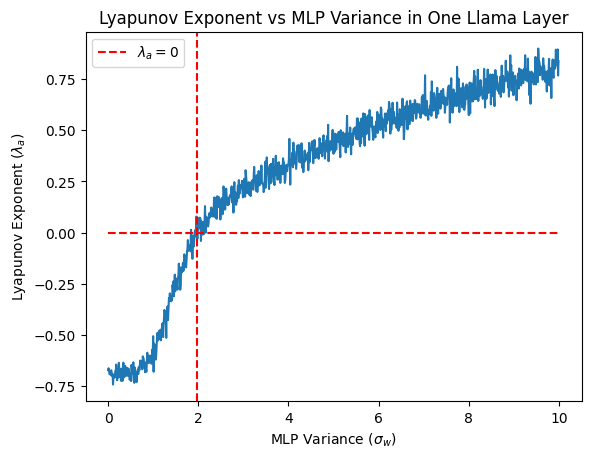

In [8]:
plt.plot(mlp_sigmas, lyapunov_exponents)
#put a vertical line at the point where the lyapunov exponent is 0
plt.axvline(x=mlp_sigmas[np.argmin(np.abs(lyapunov_exponents))], color='r', linestyle='--', label=r"$\lambda_a = 0$")
plt.hlines(0, 0, 10, colors='r', linestyles='--')
plt.xlabel(r"MLP Variance ($\sigma_w$)")
plt.ylabel(r"Lyapunov Exponent ($\lambda_a$)")
plt.title(r"Lyapunov Exponent vs MLP Variance in One Llama Layer")
plt.legend()
plt.show()

# Full Model Test

In [9]:
class PaperNorm(nn.Module):
    def __init__(self, hidden_size, eps=None):
        super().__init__()
        self.hidden_size = hidden_size
    
    def forward(self, input):
        return math.sqrt(self.hidden_size) * input / torch.norm(input, dim=-1, keepdim=True)

class StrippedLlama(nn.Module):
    def __init__(self, config, norm_func):
        super().__init__()
        self.config = config
        
        if norm_func == "rms":
            self.norm_func = LlamaRMSNorm
        elif norm_func == "layernorm":
            self.norm_func = nn.LayerNorm
        else:
            self.norm_func = PaperNorm

        self.layers = nn.ModuleList(
            [LlamaDecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )

        self.post_init()
    
    def post_init(self):
        for layer in self.layers:
            layer.input_layernorm = self.norm_func(self.config.hidden_size, eps=self.config.rms_norm_eps)
            layer.output_layernorm = self.norm_func(self.config.hidden_size, eps=self.config.rms_norm_eps)
    
    def initialize_weights(self, attention_sigma, mlp_sigma):
        for layer in self.layers:
            initialize_weights(layer, "normal", attention_sigma, mlp_sigma)
    
    def forward(self, input, position_ids=None, output_hidden_states=False):
        if position_ids is None:
            position_ids = torch.arange(0, input.shape[1]).unsqueeze(0).to(input.device)
        hidden_state = input
        hidden_states = []
        for layer in self.layers:
            hidden_state = layer(input, position_ids=position_ids)[0]
            hidden_states.append(hidden_state.squeeze(0).detach().cpu().numpy())
        if output_hidden_states:
            return hidden_state, hidden_states
        else:
            return hidden_state

In [10]:
#Define the model parameters

model_name = "meta-llama/Llama-2-7b-hf" 
config = AutoConfig.from_pretrained(model_name, token=hf_auth_token)

activation_function = "tanh" #from paper (silu is llama default)
n = 64 #input size
d = config.hidden_size
num_layers = config.num_hidden_layers
norm_func = "paper"

correlation = 0.99
attention_sigma = 1
position_ids = torch.arange(0, n).unsqueeze(0).to(device)

config.hidden_act = activation_function

model = StrippedLlama(config, norm_func).to(device)

## Lyapunov exponent over full model

In [11]:
mlp_sigmas = np.arange(0, 10, 0.1)
lyapunov_exponents = []

# Generate input
input = generate_input(n, d, correlation).to(device)
p, q = calculate_pq(input.cpu().numpy().squeeze())
model.eval()

for variance_idx, mlp_sigma in tqdm(enumerate(mlp_sigmas)):
    model.initialize_weights(attention_sigma, mlp_sigma)
    output = model(input, position_ids)
    p_prime, q_prime = calculate_pq(output.detach().cpu().numpy().squeeze())

    # Calculate Lyapunov exponent
    lyapunov_exponent = calculate_lyapunov_exponent(p, q, p_prime, q_prime)
    lyapunov_exponents.append(lyapunov_exponent)

0it [00:00, ?it/s]

100it [00:10,  9.18it/s]


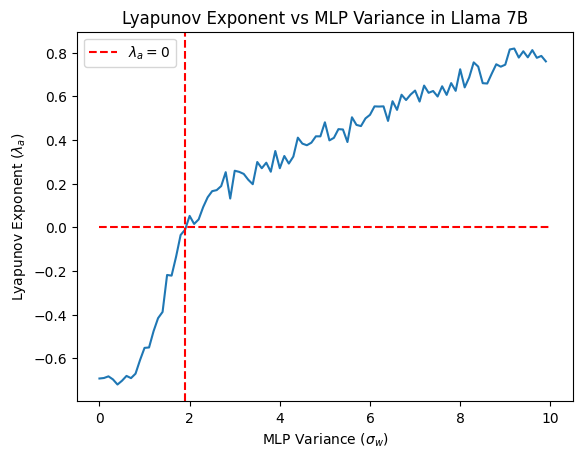

In [14]:
plt.plot(mlp_sigmas, lyapunov_exponents)
#put a vertical line at the point where the lyapunov exponent is 0
plt.axvline(x=mlp_sigmas[np.argmin(np.abs(lyapunov_exponents))], color='r', linestyle='--', label=r"$\lambda_a = 0$")
# plt.axvline(x=2, color='r', linestyle='--', label=r"$\lambda_a = 0$")
plt.hlines(0, 0, 10, colors='r', linestyles='--')
plt.xlabel(r"MLP Variance ($\sigma_w$)")
plt.ylabel(r"Lyapunov Exponent ($\lambda_a$)")
plt.title(r"Lyapunov Exponent vs MLP Variance in Llama 7B")
plt.legend()
plt.show()

## norms and angles over every layer in model

In [15]:
mlp_sigmas = [1, 2, 4]

num_runs = 100
token_norms = np.zeros((num_runs, num_layers, len(mlp_sigmas)))
token_angles = np.zeros((num_runs, num_layers, len(mlp_sigmas)))
model.eval()

for variance_idx, mlp_sigma in tqdm(enumerate(mlp_sigmas)):
    model.initialize_weights(attention_sigma, mlp_sigma)
    for run_idx in tqdm(range(num_runs)):
        # Generate input
        input = generate_input(n, d, correlation).to(device)
        output, hidden_states = model(input, position_ids, output_hidden_states=True)
        for layer_idx, hidden_state in enumerate(hidden_states):
            p, q = calculate_pq(hidden_state)
            token_norms[run_idx, layer_idx, variance_idx] = q / d
            token_angles[run_idx, layer_idx, variance_idx] = p / q

100%|██████████| 100/100 [00:12<00:00,  7.90it/s]
3it [00:37, 12.51s/it]


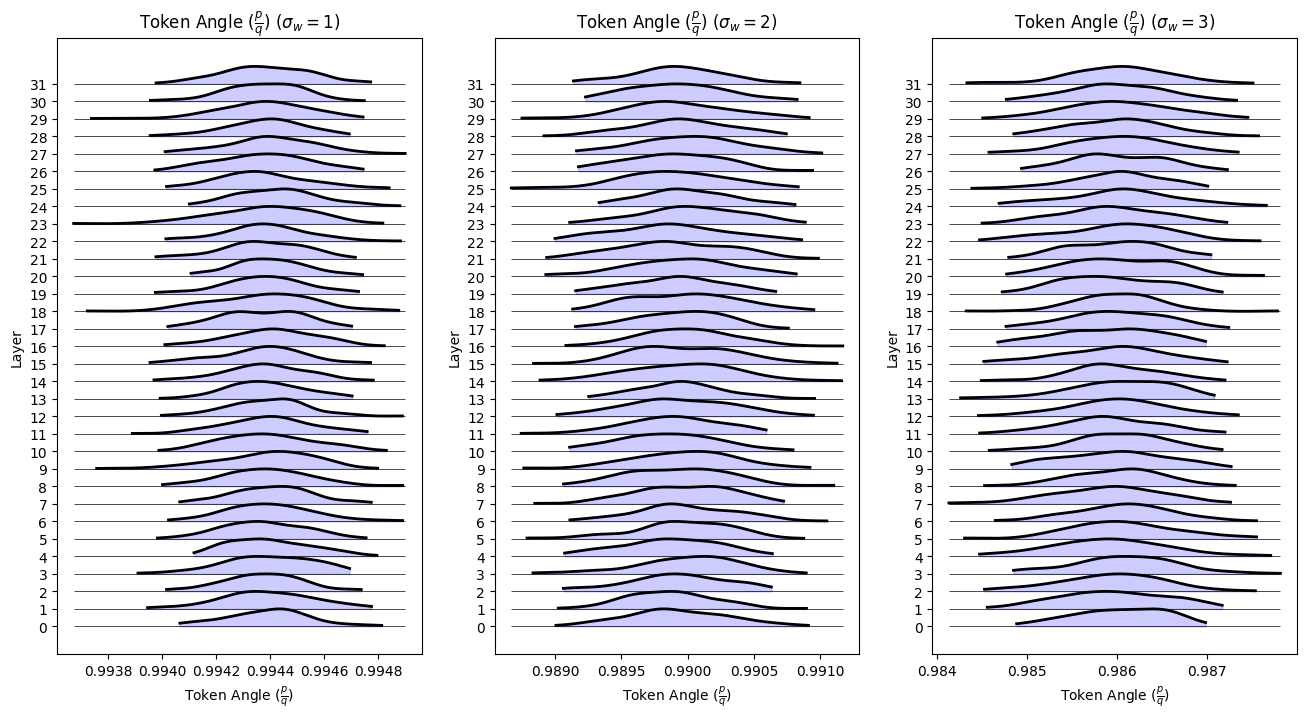

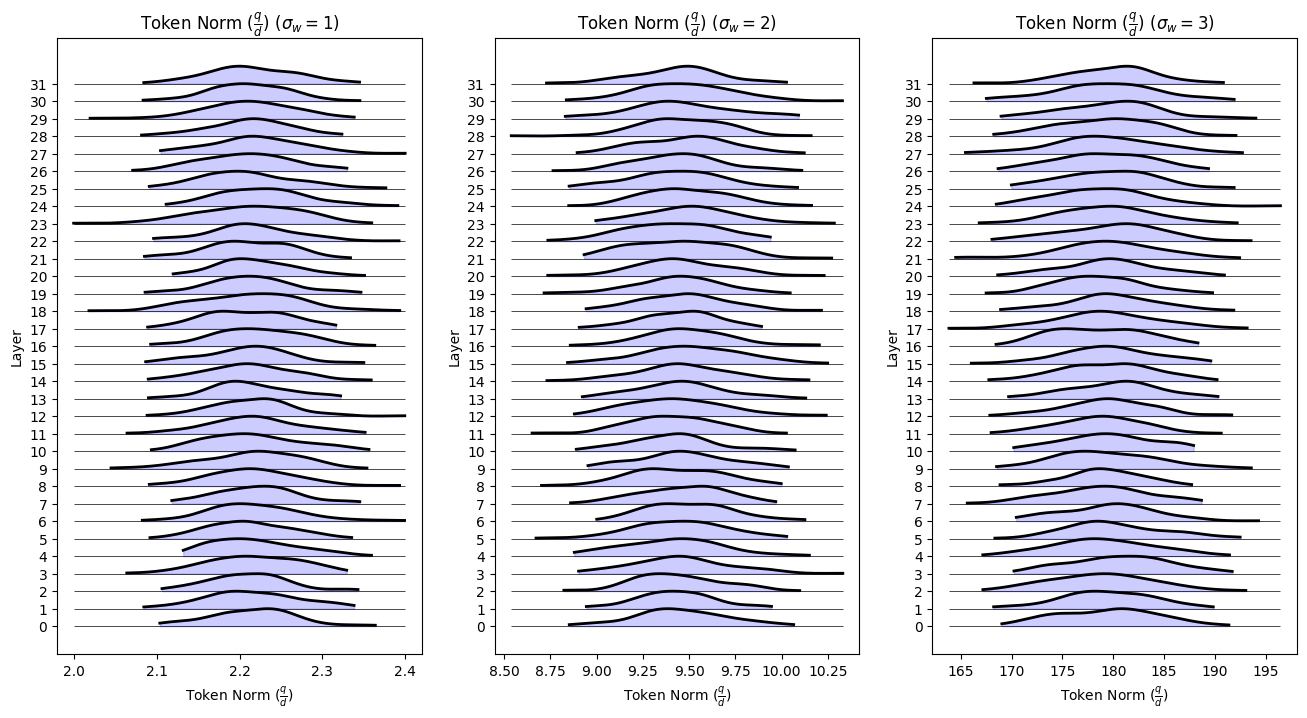

In [16]:
def plot_density(ax, data, mlp_variance, name):
    # Create the plot
    all_min = data[:, :, mlp_variance].min()
    all_max = data[:, :, mlp_variance].max()
    for layer_idx in range(data.shape[1]):
        # Calculate the density
        density = gaussian_kde(data[:, layer_idx, mlp_variance])
        min_value = data[:, layer_idx, mlp_variance].min()
        max_value = data[:, layer_idx, mlp_variance].max()
        x = np.linspace(min_value, max_value, 1000)
        y = density(x) / density(x).max()

        # Offset each layer vertically
        ax.plot(x, y + layer_idx, color='black', linewidth=2)
        ax.fill_between(x, layer_idx, y + layer_idx, color='blue', alpha=0.2)
        ax.hlines(layer_idx, all_min, all_max, color='black', linewidth=0.5)

    # Customize the plot
    ax.set_title(f'{name} ($\\sigma_w = {mlp_variance+1}$)')
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Layer')
    ax.set_yticks(range(data.shape[1]))
    ax.set_yticklabels(range(data.shape[1]))

    return fig

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
for mlp_variance in range(len(mlp_sigmas)):
    plot_density(axs[mlp_variance], token_angles, mlp_variance, r"Token Angle ($\frac{p}{q}$)")

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
for mlp_variance in range(len(mlp_sigmas)):
    plot_density(axs[mlp_variance], token_norms, mlp_variance, r"Token Norm ($\frac{q}{d}$)")

# gradient stability

In [17]:
def output_reduction_wrapper(model):
    def output_reduction(input):
        # mean 0 unit variance gaussian of same size
        random_vector = torch.randn_like(input)
        output = model(input)
        return torch.sum(output * random_vector, dim=-1)
    return output_reduction

In [18]:
mlp_sigmas = np.arange(0, 10, 0.1)
gradient_exponents = []

# Generate input
input = generate_input(n, d, correlation).to(device)

for variance_idx, mlp_sigma in tqdm(enumerate(mlp_sigmas)):
    model.initialize_weights(attention_sigma, mlp_sigma)
    reduction_function = output_reduction_wrapper(model)
    j = torch.autograd.functional.jacobian(reduction_function, input).squeeze(0).squeeze(1)
    norm = torch.norm(j)
    gradient_exponent = torch.log(norm).item()
    gradient_exponents.append(gradient_exponent)

0it [00:00, ?it/s]

100it [00:23,  4.17it/s]


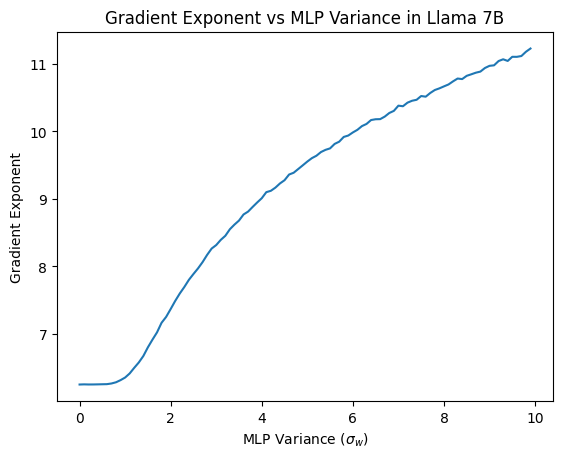

In [ ]:
plt.plot(mlp_sigmas, gradient_exponents)
plt.xlabel(r"MLP Variance ($\sigma_w$)")
plt.ylabel(r"Gradient Exponent")
plt.title(r"Gradient Exponent vs MLP Variance in Llama 7B")
plt.show()